To develop a predictive model for a fantasy football Drafting Engine. The primary objective is to predict whether a player will be 'Active' (1) or 'Out' (0) in a given game or series of games. This model aims to aid fantasy football managers in making informed decisions when selecting their roster by leveraging historical data and statistical learning techniques.

Code encompasses:

1. Data Preprocessing: Cleaning the data and preparing it for modeling, such as handling missing values and encoding categorical variables.
2. Feature Engineering: Creating new features that could enhance the model's predictive capabilities based on domain knowledge and exploratory data analysis.
3. Model Training and Selection: Utilizing various machine learning algorithms, including Decision Trees, Random Forest, and XGBoost, to train on the dataset.
4. Class Imbalance Handling: Addressing the imbalance in the dataset with Synthetic Minority Over-sampling Technique (SMOTE) to improve model fairness and accuracy.
5. Hyperparameter Tuning: Optimizing the XGBoost model's hyperparameters using GridSearchCV for better performance.
6. Model Evaluation: Assessing the model's performance on a hold-out test set using metrics appropriate for classification tasks.
7. Visualization: Plotting the decision tree to interpret the model's decision-making process.

This model will contribute to the field of sports analytics by providing insights into factors that influence player activity status, thereby enhancing the strategic elements of fantasy football management.



**IMPORTING NECESSARY LIBRARIES**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/My Drive/DCA.csv'
data = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
print(data.head())

  Position               Player Team  Depth Chart  Active 1/Out 0  \
0       QB     Joshua Dobbs (N)  ARI          1.0             1.0   
1       QB     Clayton Tune (R)  ARI          2.0             1.0   
2       QB    Kyler Murray (IR)  ARI          NaN             0.0   
3       RB      Keaontay Ingram  ARI          1.0             1.0   
4       RB  Damien Williams (N)  ARI          2.0             1.0   

   Rookie 1/ NR 0  
0             0.0  
1             1.0  
2             0.0  
3             0.0  
4             0.0  


**DATA PREPROCESSING AND ADVANCED FEATURE ENGINEERING**

In [ ]:
# Preprocessing: fill missing values and encode categorical data
data['Depth Chart'].fillna(data['Depth Chart'].median(), inplace=True)
label_encoder = LabelEncoder()
data['Position'] = label_encoder.fit_transform(data['Position'])
data['Team'] = label_encoder.fit_transform(data['Team'])
data.drop('Player', axis=1, inplace=True)  # Drop 'Player'

# Advanced Feature Engineering
data['Rookie_Depth_Interaction'] = data['Depth Chart'] * data['Rookie 1/ NR 0']
data['Inverse_Depth'] = 1 / data['Depth Chart']
data['Team_Experience'] = (1 - data['Rookie 1/ NR 0']) * data['Depth Chart']
data['Team_Position_Interaction'] = data['Team'] * data['Position']

In [ ]:
X = data.drop('Active 1/Out 0', axis=1)
y = data['Active 1/Out 0']
# Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle NaN values in features
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Handle NaN values in target variable
train_na_indices = y_train[y_train.isna()].index
X_train.drop(train_na_indices, inplace=True)
y_train.drop(train_na_indices, inplace=True)

# Apply SMOTE after handling NaN values
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Drop rows in the test set where the target variable is NaN
test_na_indices = y_test[y_test.isna()].index
X_test.drop(test_na_indices, inplace=True)
y_test.drop(test_na_indices, inplace=True)

**MODEL TRAINING**

In [ ]:
# Model 1: Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [ ]:

# Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
# Model 3: XGBoost with Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [ ]:
# Initializing GridSearchCV with the XGBoost classifier, the parameter grid, and cross-validation settings.
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='recall')
grid_search.fit(X_train_smote, y_train_smote)
best_xgb = grid_search.best_estimator_

In [ ]:
models = {'Decision Tree': dtree, 'Random Forest': rf, 'XGBoost': best_xgb}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

Model: Decision Tree
Accuracy: 0.8598726114649682

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.99      0.87      0.92       155

    accuracy                           0.86       157
   macro avg       0.49      0.44      0.46       157
weighted avg       0.97      0.86      0.91       157

--------------------------------------------------
Model: Random Forest
Accuracy: 0.8726114649681529

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.99      0.88      0.93       155

    accuracy                           0.87       157
   macro avg       0.49      0.44      0.47       157
weighted avg       0.97      0.87      0.92       157

--------------------------------------------------
Model: XGBoost
Accuracy: 0.8726114649681529

Classification Report:
               precision  

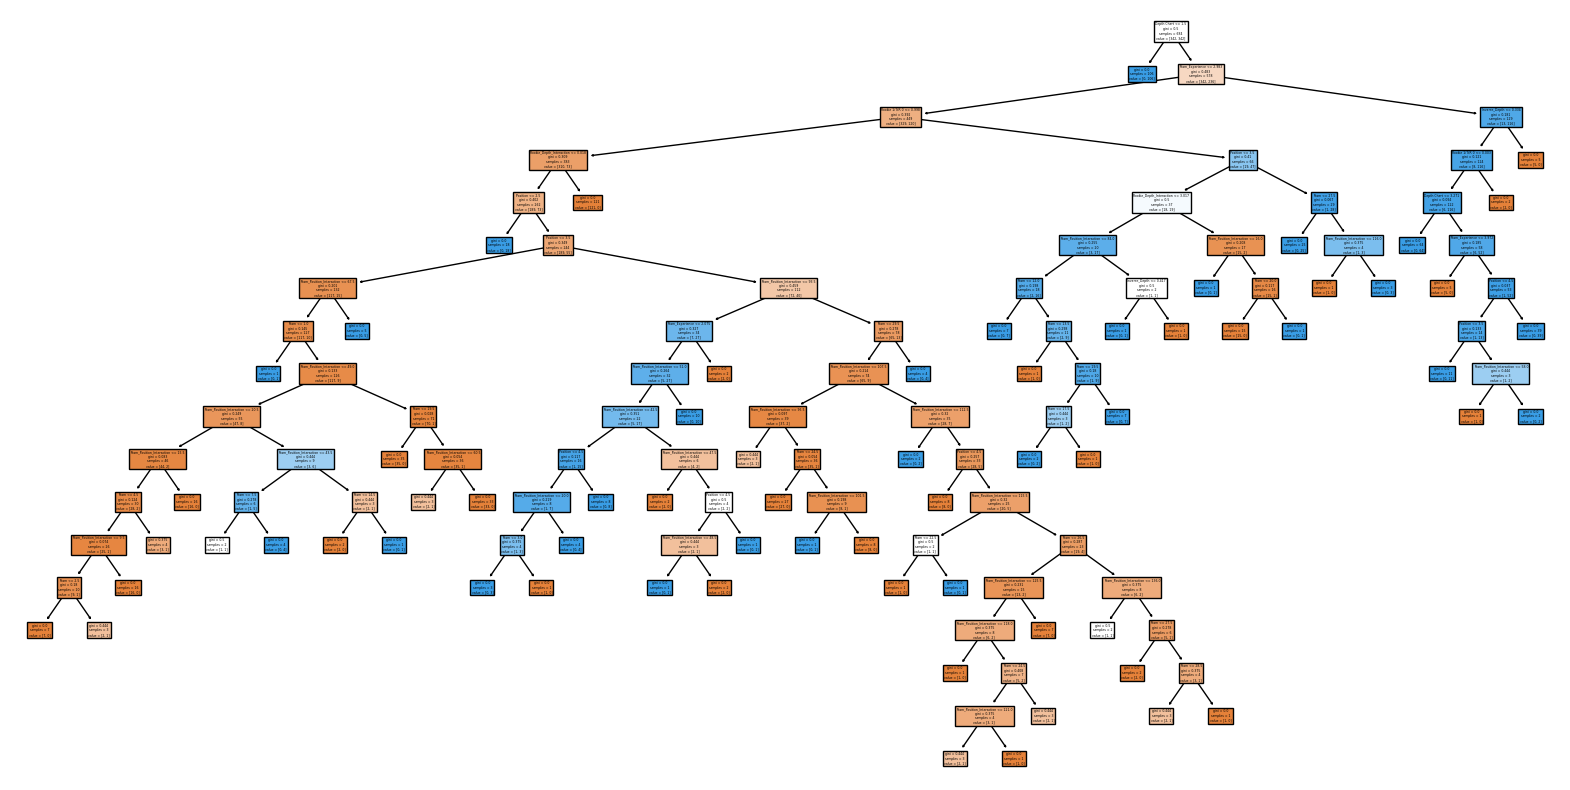

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dtree, filled=True, feature_names=X.columns)
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define a comprehensive set of hyperparameters for tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 3]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict and evaluate the best model
y_pred_xgb = best_xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Accuracy: 0.8980891719745223

Classification Report:
               precision    recall  f1-score   support

         0.0       0.06      0.50      0.11         2
         1.0       0.99      0.90      0.95       155

    accuracy                           0.90       157
   macro avg       0.53      0.70      0.53       157
weighted avg       0.98      0.90      0.94       157



In [ ]:
print(data.columns)



Index(['Position', 'Team', 'Depth Chart', 'Active 1/Out 0', 'Rookie 1/ NR 0',
       'Rookie_Depth_Interaction', 'Inverse_Depth', 'Team_Experience',
       'Team_Position_Interaction'],
      dtype='object')
